$$
\begin{matrix}
U          &          &     &          & V \\
\downarrow & \searrow &     & \swarrow & \downarrow \\
\downarrow &          & Z   &          & \downarrow \\
\downarrow &          &     &          & \downarrow \\
X          & \to      & \to & \to      & Y \\
\end{matrix}
\quad
\begin{cases}
Z = qU + sV + \varepsilon_1 \\
X = pU + \varepsilon_2 \\
Y = aX + rV + \varepsilon_3 \\
\end{cases}
\quad
\begin{cases}
\text{$U,V,\varepsilon_1,\varepsilon_2,\varepsilon_3$ are i.i.d $\sim$ Normal(0,1).} \\
E[Z^2] = q^2 + s^2 + \sigma_1^2 := 1 \\
E[X^2] = p^2 + \sigma_2^2 := 1 \\
\end{cases}
$$

<img src="IMG_8351.PNG" width=80%>

In [1]:
using Distributions
using StatsPlots
default(fmt=:png, size=(400, 250),
    titlefontsize=8, tickfontsize=6, legendfontsize=7, guidefontsize=7)
rd(x) = round(x; digits=3)

rd (generic function with 1 method)

In [2]:
function rand_XYZUV(; σ₁, σ₂, σ₃, a, p = √(1 - σ₂^2), q, r, s=√(1-q^2-σ₁^2))
    U = randn()
    V = randn()
    Z = q*U + s*V + σ₁*randn()
    X = p*U + σ₂*randn()
    Y = a*X + r*V + σ₃*randn()
    [X, Y, Z, U, V]
end

function rand_XYZUV(n;
        σ₁ = 0.2, σ₂ = 0.2, σ₃ = 0.2, 
        a = 1.0, p = √(1 - σ₂^2), q = √((1 - σ₁^2)/2), r = √10, s = √(1 - q^2 - σ₁^2))
    [rand_XYZUV(; σ₁, σ₂, σ₃, a, p, q, r) for _ in 1:n] |> stack
end

rand_XYZUV(100) .|> rd

5×100 Matrix{Float64}:
 -0.915   0.305  -0.45   1.252  -0.01   …  0.513   1.287  -0.59   -1.436
 -1.477  -2.983  -2.398  5.441  -1.12      2.448  -1.868  -3.002  -0.83
 -0.855  -0.732  -0.73   1.918   0.106     0.698   0.481  -0.867  -0.307
 -1.011   0.329  -0.381  1.253   0.063     0.396   1.553  -0.726  -1.004
 -0.142  -1.203  -0.702  1.375  -0.347     0.678  -1.037  -0.798   0.251

In [3]:
function show_XYZUV(n = 10^6;
        σ₁ = 0.2, σ₂ = 0.2, σ₃ = 0.2, 
        a = 1.0, p = √(1 - σ₂^2), q = √((1 - σ₁^2)/2), r = √10, s = √(1 - q^2 - σ₁^2))
    println("====== model parameters")
    @show rd(σ₁) rd(σ₂) rd(σ₃) rd(a) rd(p) rd(q) rd(r) rd(s) n
    println()

    data = rand_XYZUV(n; σ₁, σ₂, σ₃, a, p, q, r, s)
    X, Y, Z, U, V = eachrow(data)
    println("====== summary of data")
    @show rd.(mean.((X, Y, Z, U, V)))
    @show rd.(var.((X, Y, Z, U, V)))
    @show rd.(std.((X, Y, Z, U, V)))
    println()

    println("====== resgressions")
    println("=== Y ~ α₁X")
    @show rd(a)
    α = [X;;] \ Y
    @show rd.(α)
    println("=== Y ∼ β₁X + β₂Z")
    @show rd(a - p*q*r*s/(1 - p^2*q^2)), rd(r*s/(1 - p^2*q^2))
    β = [X Z] \ Y
    @show rd.(β)
    println("=== Y ∼ γ₁X + γ₄V")
    @show rd(a), rd(r)
    γ = [X V] \ Y
    @show rd.(γ)
    println()
    
    println("====== M-bias")
    @show rd(β[1] - a)
    println()

    println("====== errors of prediction for Y")
    err_α = @. Y - α[1]*X
    err_β = @. Y - (β[1]*X + β[2]*Z)
    err_γ = @. Y - (γ[1]*X + γ[2]*V)
    @show rd.(mean.((err_α, err_β, err_γ)))
    @show rd.(var.((err_α, err_β, err_γ)))
    @show rd.(std.((err_α, err_β, err_γ)))
    println()

    P1 = plot()
    stephist!(err_α; norm=true, label="Y ∼ X", ls=:solid)
    stephist!(err_β; norm=true, label="Y ∼ X + Z", ls=:dash)
    plot!(xguide="error of prediction for Y")
    
    P2 = plot()
    stephist!(err_α; norm=true, label="Y ∼ X", ls=:solid)
    stephist!(err_β; norm=true, label="Y ∼ X + Z", ls=:dash)
    stephist!(err_γ; norm=true, label="Y ∼ X + V", ls=:dashdot)
    plot!(xguide="error of prediction for Y")

    plot(P1, P2; size=(800, 250))
    plot!(bottommargin=4Plots.mm)
end

show_XYZUV (generic function with 2 methods)

====== model parameters
rd(σ₁) = 0.2
rd(σ₂) = 0.2
rd(σ₃) = 0.2
rd(a) = 1.0
rd(p) = 0.98
rd(q) = 0.693
rd(r) = 3.162
rd(s) = 0.693
n = 1000000

====== summary of data
rd.(mean.((X, Y, Z, U, V))) = (-0.0, 0.004, 0.0, -0.0, 0.001)
rd.(var.((X, Y, Z, U, V))) = (1.0, 11.026, 0.999, 1.0, 0.999)
rd.(std.((X, Y, Z, U, V))) = (1.0, 3.32, 0.999, 1.0, 0.999)

====== resgressions
=== Y ~ α₁X
rd(a) = 1.0
rd.(α) = [0.999]
=== Y ∼ β₁X + β₂Z
(rd(a - (p * q * r * s) / (1 - p ^ 2 * q ^ 2)), rd((r * s) / (1 - p ^ 2 * q ^ 2))) = (-1.758, 4.063)
rd.(β) = [-1.76, 4.065]
=== Y ∼ γ₁X + γ₄V
(rd(a), rd(r)) = (1.0, 3.162)
rd.(γ) = [1.0, 3.162]

====== M-bias
rd(β[1] - a) = -2.76

====== errors of prediction for Y
rd.(mean.((err_α, err_β, err_γ))) = (0.004, 0.002, 0.0)
rd.(var.((err_α, err_β, err_γ))) = (10.027, 1.137, 0.04)
rd.(std.((err_α, err_β, err_γ))) = (3.167, 1.066, 0.2)



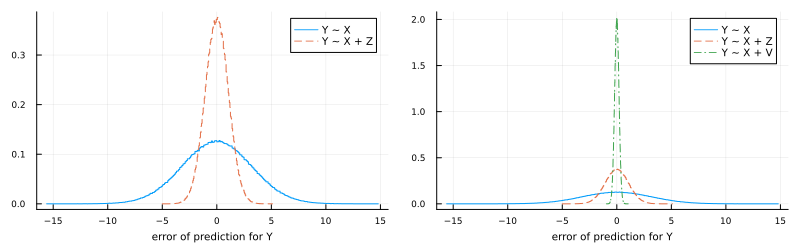

In [4]:
show_XYZUV()

$$
\begin{matrix}
U          &          &     &          & V \\
\downarrow & \searrow &     & \swarrow & \downarrow \\
\downarrow &          & Z   &          & \downarrow \\
\downarrow &          &     &          & \downarrow \\
X          & \to      & \to & \to      & Y \\
\end{matrix}
\quad
\begin{cases}
Z = qU + sV + \varepsilon_1 \\
X = pU + \varepsilon_2 \\
Y = aX + rV + \varepsilon_3 \\
\end{cases}
\quad
\begin{cases}
\text{$U,V,\varepsilon_1,\varepsilon_2,\varepsilon_3$ are i.i.d $\sim$ Normal(0,1).} \\
E[Z^2] = q^2 + s^2 + \sigma_1^2 := 1 \\
E[X^2] = p^2 + \sigma_2^2 := 1 \\
\end{cases}
$$